<a href="https://colab.research.google.com/github/mukund-rajukumar/My-VisionAI-Projects/blob/main/FoodAndBevPackageDetection/FnB_CPG_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optimizing Vending Machine Inventory with AI: A Deep Dive into Model Selection

### Introduction:
Vending machines, once simple dispensers, are evolving into data-driven hubs. To maximize customer satisfaction and revenue, owners need real-time insights into product consumption. This article explores how Vision AI can enhance inventory management by using cameras to monitor purchases.

### The Challenge:
Traditional inventory methods often rely on manual checks or unreliable sensors. Vision AI offers a more accurate and efficient solution. However, the diversity of products in vending machines, coupled with varying package sizes and shapes, presents a unique challenge.

### The Solution: Deep Learning
Deep learning, a subset of AI, is ideally suited for this task. It can learn complex patterns from vast datasets, making it capable of identifying and classifying products even in the face of variations.

### Beyond the model: The Vision AI stack
While the AI model is crucial, it is part of the larger vision AI solution stack. Key components include:
1. Hardware Selection: Choosing the right camera with desired FoV that can capture high quality images in various lighting conditions
2. Hardware Installation: Ensuring cameras are securely mounted and positioned to capture optimal product views without being intrusive or compromising customer experience.
3. Data Transmission: Selecting reliable communication mechanism to transmit image/video data to the processing system
4. Processing System: Determining whether to run the AI model on-device (edge computing) or in the cloud or in a hybrid fashion.
5. Data Storage: Saving necessary data to support future analysis and reporting
6. Data Presentation: Helping owners visualize the insights via a front-end application

### AI Model Development
To accurately track product purchases, we need a reference database containing images and corresponding information for each product in the vending machine, including product name and location within the machine. Our motion-detection camera captures footage whenever a customer makes a purchase. By analyzing the movement of the product from its slot, we can effectively identify the specific item purchased. <br>

#### First Choice: Multimodal Large Language Model  
A promising approach is to leverage a Multimodal Large Language Model (MLLM) to identify products in the image. MLLMs, trained on vast amounts of text and image data, possess advanced capabilities in understanding and processing both visual and textual information. Hence, there is a high chance that it can perform zero-shot detection of product packages in images. In addition, it is easy to invoke these models by only providing a detailed prompt through an API call. If this works, it would eliminate the need for complex, custom-built models, simplifying the development process.

In addition, we expect the model to return the names of all the packaged products in the image and their location in the form of bounding box. <br>

There are 2 types of tasks we want the LMM to be good at:
1. Visual reasoning based on text in images - TextVQA is the standard benchmark to measure a model's performance in this regard
2. Visual search to localize key objects in the image.

Below is the list of top MLLMs available today. Let's look at each model documentation to find out their performance against these standard benchmarks:
1. Gemini 1.5 Pro: https://storage.googleapis.com/deepmind-media/gemini/gemini_v1_5_report.pdf
2. GPT4o: https://openai.com/index/gpt-4-research/
3. Claude3: https://www.anthropic.com/news/claude-3-family, https://docs.anthropic.com/en/docs/build-with-claude/vision
4. Grok-1.5v: https://x.ai/blog/grok-1.5v
5. Llamma3-V 405B: https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices/, https://scontent-sjc3-1.xx.fbcdn.net/v/t39.2365-6/453304228_1160109801904614_7143520450792086005_n.pdf

6. NVLM1.0: https://research.nvidia.com/labs/adlr/NVLM-1/


In [216]:
#@title LLM Performance Comparison
import pandas as pd
import numpy as np

df = pd.DataFrame({'Model':                  ['Gemini-1.5-Pro', 'GPT-4V', 'Claude3', 'Grok-1.5v', 'Llamma3-V 405B', 'NVLM1.0 72B']})
df = pd.concat([df, pd.DataFrame({'TextVQA': [78.7,              78,      None,      78.1,       84.8,             82.1]})], axis=1)
# df['TextVQA'] = df['TextVQA'].map(lambda x: f"{x:.1f}%")

df = pd.concat([df, pd.DataFrame({'VQAv2':   [83,                77.2,    None,      None,       80.2,             85.4]})], axis=1)
# df['VQAv2'] = df['VQAv2'].map(lambda x: f"{x:.1f}%" if x is not None else x)

# df = pd.concat([df, pd.DataFrame({'V* Bench':[71.7,            None,    None,      None,     None ]})], axis=1)
# df['V* Bench'] = df['V* Bench'].map(lambda x: f"{x:.1f}%" if x is not None else x)

print("Note: nan% implies benchmark scores not published")
print(df.to_markdown(index=False, numalign="left", stralign="left"))
#df

Note: nan% implies benchmark scores not published
| Model          | TextVQA   | VQAv2   |
|:---------------|:----------|:--------|
| Gemini-1.5-Pro | 78.7      | 83      |
| GPT-4V         | 78        | 77.2    |
| Claude3        | nan       | nan     |
| Grok-1.5v      | 78.1      | nan     |
| Llamma3-V 405B | 84.8      | 80.2    |
| NVLM1.0 72B    | 82.1      | 85.4    |


In [200]:
#@title Shortlisted LLMs
Ptop_3_indices = df['TextVQA'].nlargest(3).index
print(f"We will evaluate the top 3 models:")
print(f"1. {df['Model'][top_3_indices[0]]}")
print(f"2. {df['Model'][top_3_indices[1]]}")
print(f"3. {df['Model'][top_3_indices[2]]}")

We will evaluate the top 3 models:
1. Llamma3-V 405B
2. NVLM1.0 72B
3. Gemini-1.5-Pro


###Utility Functions

In [239]:
#@title Install Dependencies
if importlib.util.find_spec('tabulate') is None:
  %pip install tabulate

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np
import os
import cv2  # For reading images
import yaml
import time
import re

In [240]:
#@title Function: Count Model Parameters
def count_params(model):
  """Counts the total number of trainable parameters in a PyTorch model.

  Args:
      model (torch.nn.Module): The PyTorch model for which to count parameters.

  Prints:
      The total number of parameters in the model, formatted to 1 decimal place in millions.
  """
  total_params = 0
  for param in model.parameters():
    num_elements = 1
    for dim in param.size():
      num_elements *= dim
    total_params += num_elements
  print(f"{total_params / 1000000:.1f} million parameters")


In [241]:
#@title Function: Make API Call to LLM

def make_api_call(prompt, image, model):
  """Calls a Large Language Model (LLM) API to generate text based on a prompt and image.

  Args:
      prompt (str): The text prompt for the LLM.
      image (Image.Image): The image to be analyzed by the LLM.
      model (object): The LLM API model object (specific implementation details may vary).

  Returns:
      genai.TextGenerationResponse (or equivalent): The response object from the LLM API,
          containing the generated text or relevant data.

  Raises:
      Exception: If an error occurs during the API call.
  """
  try:
    response = model.generate_content([prompt, image])
    return response
  except Exception as e:
    if e.code == 429:
      print ("Rate Limit Error")
      # Implement retry logic or handle the error appropriately
      return handle_rate_limit_error(prompt, image)

    # Handle other exceptions or return None if no response is available
    print(f"An error occurred: {e}")
    return None


In [242]:
#@title Function: Handle Rate Limit Error for LLM Calls
def handle_rate_limit_error(prompt, image):
  """Handles rate limit errors from the LLM API by implementing a retry logic.

  Args:
      prompt (str): The text prompt for the LLM.
      image (Image.Image): The image to be analyzed by the LLM.

  Returns:
      genai.TextGenerationResponse (or equivalent): The response object from the LLM API after retrying.
  """
  time.sleep(60)
  print(f"Retrying LLM API call due to rate limit...")
  return model.generate_content([prompt, image])


In [287]:
#@title Function: Extract Label names and bounding boxes from LLM response

def extract_pred_labels(text, image):
  """Parses the LLM output text to extract predicted labels and bounding boxes.

  Args:
      text (str): The text output from the LLM API containing product names and bounding boxes.
      image (Image.Image): The image for which the labels were generated by the LLM.

  Returns:
      list: A list of dictionaries, where each dictionary represents a product with its
          name and bounding box coordinates.

  Raises:
      ValueError: If the provided regular expression pattern for parsing the LLM output is invalid.
  """
  # The input text to parse
  # Define a regular expression pattern to match product names and bounding box coordinates
  # pattern = r"(\d+) (\d+) (\d+) (\d+) (.+)" #72 388 153 444 Utz Potato Chips
  pattern = r"(\w[\w\s'’\-]+)\s\[(\d+)[,\s]+(\d+)[,\s]+(\d+)[,\s]+(\d+)\]" #Utz Potato Chips [64 395 158 455] \nDoritos Spicy Nacho [59, 464, 162, 534]

  try:
    # Find all matches in the text
    matches = re.findall(pattern, text)
  except re.error as e:
    raise ValueError(f"Invalid regular expression pattern for parsing LLM output: {pattern}") from e

  # Create a list of dictionaries to store product name and bounding box coordinates
  pred_labels = []
  for match in matches:
    # Extract bounding box coordinates and product name
    # For pattern = r"(\d+) (\d+) (\d+) (\d+) (.+)" #72 388 153 444 Utz Potato Chips
    # bbox = (int(match[0])/1000, int(match[1])/1000, int(match[2])/1000, int(match[3])/1000)  # Assuming x1, y1, x2, y2 order
    # product_name = match[4]

    # For pattern = r"(\w[\w\s'’\-]+)\s\[(\d+)[,\s]+(\d+)[,\s]+(\d+)[,\s]+(\d+)\]" #Utz Potato Chips [64 395 158 455] \nDoritos Spicy Nacho [59, 464, 162, 534]
    bbox = (int(match[2])/1000, int(match[1])/1000, int(match[4])/1000, int(match[3])/1000)  # Assuming y1, x1, y2, x2 order
    product_name = match[0]

    # Create a dictionary to store product information
    pred_labels.append({"label": product_name,
                        "bbox": bbox})

  # Plot the image with classification info overlaid
  width, height = image.size

  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(10, 10))

  # Display the image
  ax.imshow(image)

  # Plot the bounding boxes
  for product in pred_labels:
    print(product)
    bbox = product['bbox']
    # Denormalize the bounding box to image size
    x1, y1, x2, y2 = bbox

    x1 = int(x1 * width)
    x2 = int(x2 * width)
    y1 = int(y1 * height)
    y2 = int(y2 * height)

    # Create a rectangle
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
    # Add the rectangle to the plot
    ax.add_patch(rect)

    # Annotate with the product's brand and name
    ax.text(x1, y1 - 5, product['label'], color='yellow', fontsize=12, bbox=dict(facecolor='g', edgecolor='g'))

  # Show the plot
  plt.show()
  return pred_labels


In [245]:
#@title Function: Load class names from yaml file

def load_class_labels(yaml_path):
  """Loads class labels from a YAML file.

  Args:
      yaml_path (str): The path to the YAML file containing the class labels.

  Returns:
      list: A list of class labels.
  """

  with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)
  return data['names']  # 'names' contains the list of class labels


In [246]:
#@title Function: Extract bounding boxes and class names from Yolo format test data and overlay on image

def extract_image_bboxes(img, label_path, class_labels):
  """Extracts bounding boxes and class labels from a label file and plots them on an image.

  Args:
      img (Image.Image): The image to plot the bounding boxes on.
      label_path (str): The path to the label file containing bounding box information.
      class_labels (list): A list of class labels corresponding to the class IDs in the label file.

  Returns:
      list: A list of dictionaries containing extracted image label information (class ID and bounding box coordinates).

  Raises:
      ValueError: If the label file format is invalid (expected format: class_id x_center y_center width height per line).
  """

  # Create a plot
  fig, ax = plt.subplots(1, figsize=(10, 10))
  ax.imshow(img)

  # Read the label file and extract bounding boxes
  image_labels = []
  try:
    with open(label_path, 'r') as f:
      for line in f.readlines():
        class_id, x_center, y_center, width, height = map(float, line.split())
        # Convert normalized coordinates to absolute pixel values
        x1n = (x_center - width / 2)
        y1n = (y_center - height / 2)
        x2n = (x_center + width / 2)
        y2n = (y_center + height / 2)
        image_labels.append({'class_id': class_id, 'bbox': (x1n, y1n, x2n, y2n)})
  except ValueError:
    raise ValueError(f"Invalid label file format. Expected format: class_id x_center y_center width height per line.")

  # Plot bounding boxes and labels
  for image_label in image_labels:
    class_id = image_label['class_id']
    x1n, y1n, x2n, y2n = image_label['bbox']
    img_w, img_h = img.size
    width_abs = (x2n - x1n) * img_w
    height_abs = (y2n - y1n) * img_h
    x_min = x1n * img_w
    y_min = y1n * img_h

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((x_min, y_min), width_abs, height_abs, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Optionally, annotate the class label
    ax.text(x_min, y_min, class_labels[class_id], color='white', fontsize=12, bbox=dict(facecolor='r', edgecolor='r'))

  # Show the plot
  plt.show()
  return image_labels


In [312]:
#@title Function: Plot ground truth and predicted bounding boxes on image

def get_pred_and_plot_results(img, pred_labels, ref_labels):
  """Plots both reference and predicted bounding boxes with IoU on the same image.

  Args:
      img (Image.Image): The image to plot the bounding boxes on.
      pred_results (list): A list of dictionaries containing reference and predicted label information
          (including bounding boxes and IoU).

  Raises:
      ValueError: If the predicted results list does not contain the expected keys ('ref_label', 'pred_label', 'iou').
  """

  pred_results = []
  for pred_label in pred_labels:
    px1, py1, px2, py2 = pred_label['bbox']
    max_iou = 0
    max_iou_ind = 0
    iou2 = 0
    iou2_ind = 0
    class_id = 0
    for index, ref_label in enumerate(ref_labels):
      rx1, ry1, rx2, ry2 = ref_label['bbox']
      cid = ref_label['class_id']
      iou = calculate_iou((rx1, ry1, rx2, ry2), (px1, py1, px2, py2))
      if iou > max_iou:
        max_iou = iou
        max_iou_ind = index
        class_id = cid
      elif iou > iou2:
        iou2 = iou
        iou2_ind = index
      # print(f"ref: {rx1:.3f} {ry1:.3f} {rx2:.3f} {ry2:.3f}, pred: {px1:.3f} {py1:.3f} {px2:.3f} {py2:.3f}, iou: {iou:.3f}")

    pred_results.append({'pred_label': pred_label, 'ref_label': ref_labels[max_iou_ind], 'iou': max_iou, 'class_name':class_labels[class_id], 'iou2': iou2, 'ref_label2': class_labels[ref_labels[iou2_ind]['class_id']]})

  # Create a plot
  fig, ax = plt.subplots(1, figsize=(10, 10))
  ax.imshow(img)

  # Validate predicted results format
  if not all(key in pred_result for key in ['ref_label', 'pred_label', 'iou'] for pred_result in pred_results):
    raise ValueError("Invalid format for predicted results. Expected dictionaries with 'ref_label', 'pred_label', and 'iou' keys.")

  for pred_result in pred_results:
    rx1n, ry1n, rx2n, ry2n = pred_result['ref_label']['bbox']
    px1n, py1n, px2n, py2n = pred_result['pred_label']['bbox']

    # Calculate image dimensions and absolute bounding box coordinates
    img_w, img_h = img.size
    rwidth_abs = (rx2n-rx1n) * img_w
    rheight_abs = (ry2n-ry1n) * img_h
    rx_min = rx1n*img_w
    ry_min = ry1n*img_h

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((rx_min, ry_min), rwidth_abs, rheight_abs, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

    pwidth_abs = (px2n-px1n) * img_w
    pheight_abs = (py2n-py1n) * img_h
    px_min = px1n*img_w
    py_min = py1n*img_h

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((px_min, py_min), pwidth_abs, pheight_abs, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    # show IoU for each predicted label
    ax.text(px_min, py_min, f"{pred_result['iou']:.3f}", color='white', fontsize=12, bbox=dict(facecolor='r', edgecolor='r'))

  # Show the plot
  plt.title(f"IoU of bounding Boxes (Ground Truth in GREEN, Prediction in BLUE)")
  plt.show()

  return pred_results


In [248]:
#@title Function: Compute IoU between 2 bounding boxes

def calculate_iou(box1, box2):
  """Calculates the Intersection over Union (IoU) of two bounding boxes.

  Args:
    box1: A tuple or list representing the bounding box coordinates (x1, y1, x2, y2).
    box2: A tuple or list representing the bounding box coordinates (x1, y1, x2, y2).

  Returns:
    The IoU value between the two bounding boxes.
  """

  # Extract coordinates
  x1_1, y1_1, x2_1, y2_1 = box1
  x1_2, y1_2, x2_2, y2_2 = box2

  # Calculate the coordinates of the intersection rectangle
  x_left = max(x1_1, x1_2)
  y_top = max(y1_1, y1_2)
  x_right = min(x2_1, x2_2)
  y_bottom = min(y2_1, y2_2)

  # Calculate the area of the intersection rectangle
  intersection_area = max(0, x_right - x_left + 1) * max(0, y_bottom - y_top + 1)

  # Calculate the area of each bounding box
  box1_area = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
  box2_area = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)

  # Calculate the IoU
  iou = intersection_area / float(box1_area + box2_area - intersection_area)

  return iou


In [383]:
#@title Function: Check for match/similarity between 2 text labels describing object in image
def check_label_match(pred_label, true_label):
  """Checks the similarity between two labels based on common words.

  Args:
    pred_label: The predicted label.
    true_label: The ground truth label.

  Returns:
    True if the labels share at least 2 common words, False otherwise.
  """

  pred_label = pred_label.replace("-"," ")
  pred_words = pred_label.lower().split()
  true_words = true_label.lower().split()
  len_true_words = len(true_words)
  match_count = 0

  for word in pred_words:
    # ^: This is a negation operator
    pattern = r"[^\w\s&]"
    # Remove special characters using the substitute method
    cleaned_word = re.sub(pattern, "", word)
    # if cleaned_word != word:
    #   print(cleaned_word)

    if cleaned_word in true_words:
      # print(f"Found match: {word}")
      match_count += 1
      true_words.remove(cleaned_word)

  if match_count > 1:
    return True, match_count
  elif match_count == 1 and len_true_words == 1:
    return True, match_count
  else:
    return False, match_count

In [391]:
#@title Function: Compute Accuracy metrics for Object Detection

def compute_detection_metrics(pred_results):
  """Prints the detection metrics for a binary classification task.

  Args:
      tp (int): The number of true positives.
      fp (int): The number of false positives.
      tn (int): The number of true negatives.
      fn (int): The number of false negatives.

  Prints:
      The accuracy, precision, recall, and F1-score of the classification task.
  """

  tp = fn = fp = tn = 0
  results = []
  for pred_result in pred_results:
    pred_label  = pred_result['pred_label']['label']
    true_label = pred_result['class_name']

    IsMatch, count = check_label_match(pred_label, true_label)
    if IsMatch:
      # results.append(["MATCH", pred_label, true_label, count, pred_result['iou'], pred_result['iou2'], pred_result['ref_label2']])
      results.append(["MATCH", pred_label, true_label, count, pred_result['iou']])
      tp += 1
    else:
      # results.append(["NO MATCH", pred_label, true_label, count, pred_result['iou'], pred_result['iou2'], pred_result['ref_label2']])
      results.append(["NO MATCH", pred_label, true_label, count, pred_result['iou']])
      fp += 1

  # Create a DataFrame from the results list
  df = pd.DataFrame(results, columns=["Result", "Predicted Label", "True Label", "Matched Word Count", "IoU"])
  # print(df)
  # # Print the DataFrame as a table
  print(df.to_markdown(index=False, numalign="center", stralign="left"))

  fn = max(len(ref_labels) - len(pred_labels),0)
  # print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

  accuracy = tp/(tp+fp+tn+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1_score = 2*(precision * recall)/(precision + recall)
  print("\nDetection Metrics")
  print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
  print(f"Accuracy: {accuracy * 100:.2f}%")
  print(f"Precision: {precision * 100:.2f}%")
  print(f"Recall: {recall * 100:.2f}%")
  print(f"F1 Score: {f1_score * 100:.2f}%")

  return accuracy, precision, recall, f1_score


### Load Test Data

/Users/mukund/Documents/HealthyYouVendingProject


/opt/homebrew/Cellar/jupyterlab/4.2.3/libexec/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/mukund/Documents/HealthyYouVendingProject


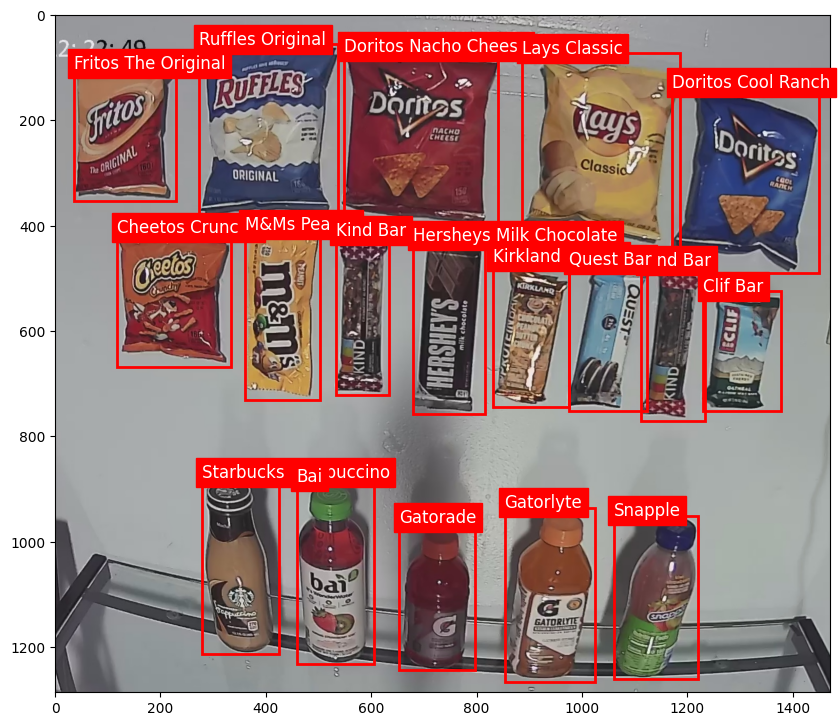

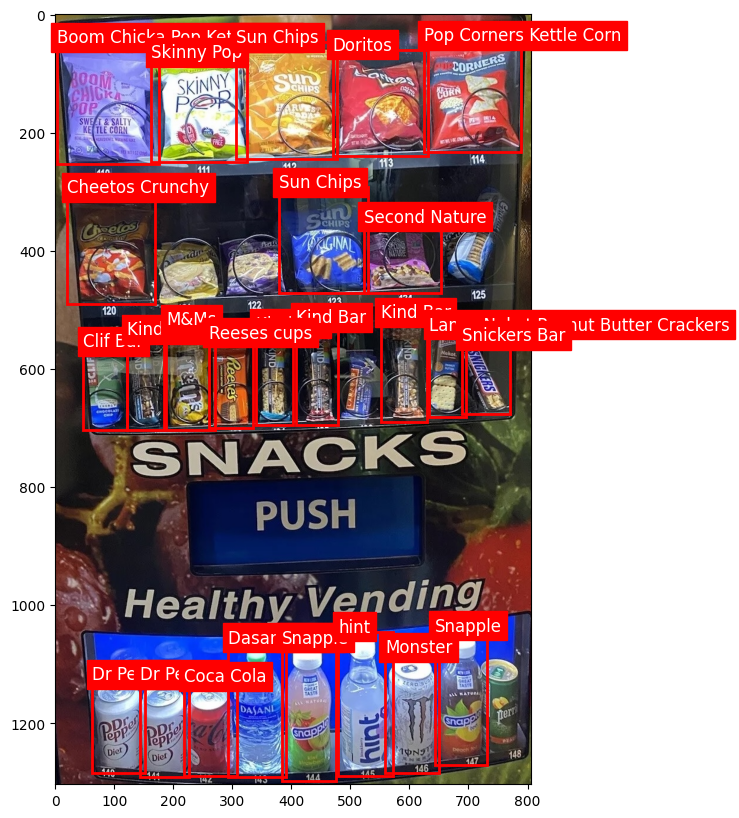

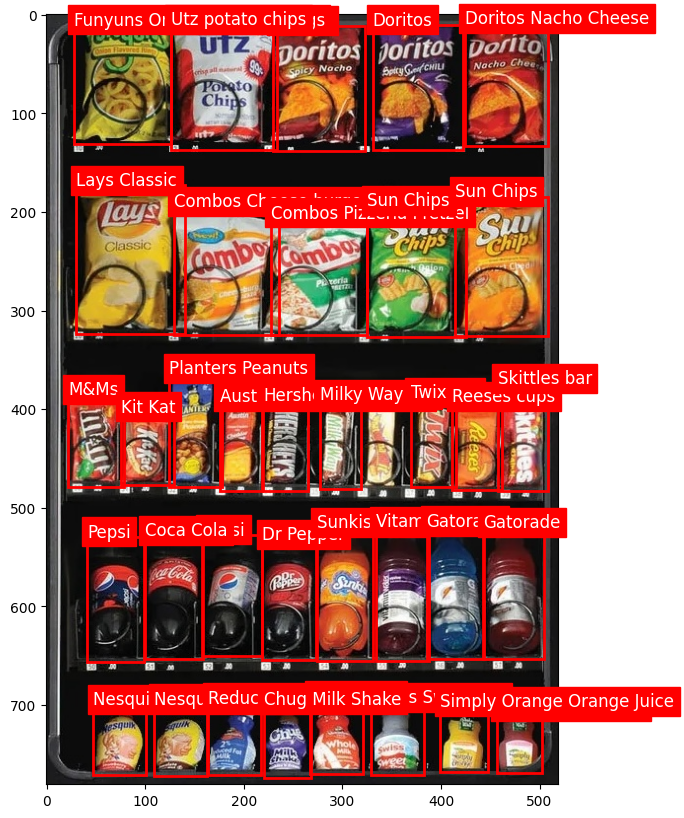

In [385]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import os

# In general, use ! if the command is one that's okay to run in a separate shell.
# Use % if the command needs to be run on the specific notebook.
if os.environ.get('HOME') == "/Users/mukund":
  %cd '/Users/mukund/Documents/HealthyYouVendingProject'
!pwd

# Define paths to the dataset
dataset_dir = './fnb-dataset'
images_dir = os.path.join(dataset_dir, 'images', 'Test')
labels_dir = os.path.join(dataset_dir, 'labels', 'Test')
data_yaml_path = os.path.join(dataset_dir, 'data.yaml')

# Load class labels from the data.yaml file
class_labels = load_class_labels(data_yaml_path)

# List of image files
image_files = os.listdir(images_dir)
num_images = len(image_files)

# Loop through the test images and plot them with their bounding boxes
test_data = []
for image_file in image_files:
  image_path = os.path.join(images_dir, image_file)
  # image = cv2.imread(image_path)
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB format for display
  image = Image.open(image_path)
  # print(f"{img_fname} dim: {images[-1].size}")
  label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))  # Assuming the labels have the same name as the images
  labels = extract_image_bboxes(image, label_path, class_labels)
  test_data.append({'image': image, 'filename': image_file, 'labels': labels})

# plt.subplots(nrows=1, ncols=num_images, figsize=(15, 15))
# for i, image in enumerate(images):
#   plt.subplot(1, num_images, i+1)
#   resized_image = image.resize((1024, 1024), Image.Resampling.NEAREST)
#   plt.imshow(resized_image)
#   plt.title(f"{img_fnames[i]} {images[i].size}")
#   plt.axis('off')

# plt.show()

### Model 1: Gemini 1.5 Pro

In [304]:
#@title Load Model
# Setup genAI model to generate label for images
import importlib
if importlib.util.find_spec('google-generativeai') is None:
  %pip install google-generativeai
import google.generativeai as genai

try:
  import google.colab
  from google.colab import userdata
  api_key=userdata.get('GOOGLE_API_KEY')

except ImportError:
  import json
  print("Warning: Not running in Google Colab. Some functionalities may be limited.")
  with open('credentials.json', 'r') as f:  # Open the file in read mode ('r')
    credentials = json.load(f)
  api_key = credentials['GOOGLE_API_KEY']

genai.configure(api_key=api_key)
# Gemini-1.5-Flash probably a 32B param model, 1.5-Pro a 120B param model
# (https://www.reddit.com/r/LocalLLaMA/comments/1cxlsa9/i_read_the_full_gemini_15_may_technical_paper_i/)
#gemini_model = genai.GenerativeModel('gemini-1.5-flash')
gemini_model = genai.GenerativeModel('gemini-1.5-pro')

#img_desc_prompt = "This image contains several packaged food and beverages. Provide the brand name and the detailed product name of each of the products. Don't use any markdown. Also provide each product's bounding box in [ymin, xmin, ymax, xmax] format"
#img_desc_prompt = "This image shows multiple packaged food and beverage products. Identify the brand and full product name for each item. Additionally, provide the bounding box coordinates for each product in the format [ymin, xmin, ymax, xmax], without using any markdown."
img_desc_prompt = "This image shows multiple packaged food and beverage products. Provide the brand and full product name for each item. Don't use any markdown. Additionally, provide the bounding box coordinates for each product in the format [ymin, xmin, ymax, xmax]"

Note: you may need to restart the kernel to use updated packages.


### RUN TESTS

vending2.jpg
prompt_token_count: 309
candidates_token_count: 440
total_token_count: 749

models/gemini-1.5-pro
{'label': 'Fritos The Original Corn Chips', 'bbox': (0.027, 0.072, 0.142, 0.277)}
{'label': 'Ruffles Original Potato Chips', 'bbox': (0.179, 0.037, 0.333, 0.311)}
{'label': 'Doritos Nacho Cheese Flavored Tortilla Chips', 'bbox': (0.351, 0.063, 0.579, 0.337)}
{'label': 'Lays Classic Potato Chips', 'bbox': (0.612, 0.082, 0.788, 0.382)}
{'label': 'Doritos Cool Ranch Flavored Tortilla Chips', 'bbox': (0.785, 0.147, 0.954, 0.406)}
{'label': "Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks", 'bbox': (0.067, 0.359, 0.215, 0.561)}
{'label': "M'S Peanut Chocolate Candies", 'bbox': (0.233, 0.352, 0.319, 0.557)}
{'label': 'KIND Bar', 'bbox': (0.347, 0.371, 0.393, 0.609)}
{'label': "Hershey's Milk Chocolate Bar", 'bbox': (0.42, 0.366, 0.577, 0.643)}
{'label': 'Kirkland Signature Protein Bar Chocolate Peanut Butter', 'bbox': (0.597, 0.378, 0.664, 0.64)}
{'label': 'Cream', 'bbox': (0.686

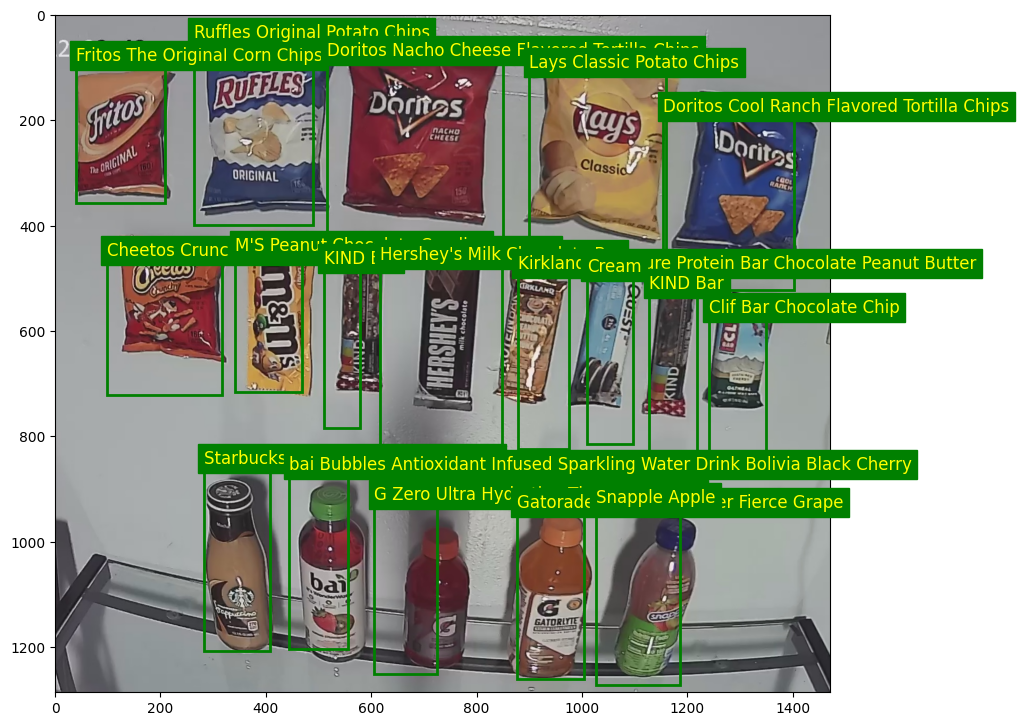

vending5-1.jpg
prompt_token_count: 309
candidates_token_count: 755
total_token_count: 1064

models/gemini-1.5-pro
{'label': 'Salty Kettle Corn', 'bbox': (0.035, 0.022, 0.186, 0.187)}
{'label': 'Skinny Pop Original Popcorn', 'bbox': (0.213, 0.049, 0.356, 0.186)}
{'label': 'Sun Chips Harvest Cheddar Flavored Whole Grain Snacks', 'bbox': (0.385, 0.041, 0.56, 0.193)}
{'label': 'Doritos Nacho Cheese Flavored Tortilla Chips', 'bbox': (0.591, 0.038, 0.758, 0.193)}
{'label': 'Air Cornners White Cheddar Puffcorn', 'bbox': (0.785, 0.038, 0.946, 0.193)}
{'label': "Cheetos Flamin' Hot Cheese Flavored Snacks", 'bbox': (0.041, 0.274, 0.182, 0.421)}
{'label': 'Pringles Original Cheddar Cheese Crisps', 'bbox': (0.198, 0.279, 0.338, 0.421)}
{'label': 'Late July Restaurant Style Tortilla Chips', 'bbox': (0.361, 0.285, 0.486, 0.421)}
{'label': 'Sun Chips Original Flavored Whole Grain Snacks', 'bbox': (0.498, 0.272, 0.658, 0.423)}
{'label': 'Second Nature Smart Mix Trail Mix', 'bbox': (0.675, 0.288, 0.808

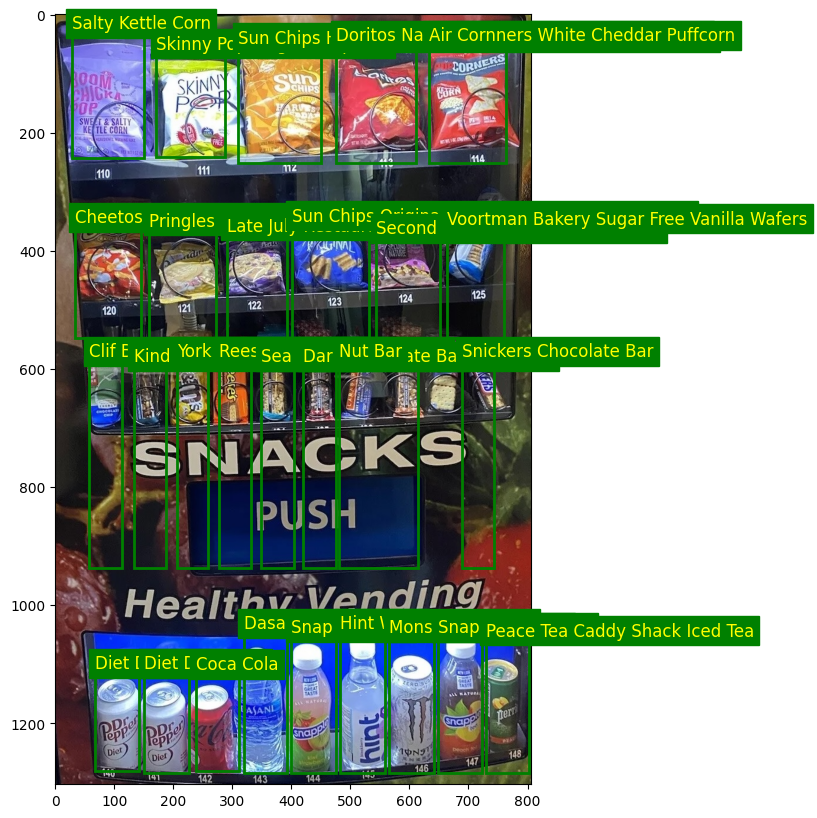

vending3-1.jpg
prompt_token_count: 309
candidates_token_count: 909
total_token_count: 1218

models/gemini-1.5-pro
{'label': 'Funyuns Onion Flavored Rings', 'bbox': (0.071, 0.01, 0.248, 0.174)}
{'label': 'Utz Potato Chips', 'bbox': (0.253, 0.018, 0.421, 0.166)}
{'label': 'Doritos Spicy Nacho', 'bbox': (0.43, 0.021, 0.602, 0.166)}
{'label': 'Doritos Spicy Sweet Chili', 'bbox': (0.612, 0.021, 0.783, 0.169)}
{'label': 'Doritos Nacho Cheese', 'bbox': (0.791, 0.021, 0.963, 0.169)}
{'label': 'Lays Classic Potato Chips', 'bbox': (0.071, 0.245, 0.245, 0.421)}
{'label': 'Combos Cheddar Cheese Pretzel Snack', 'bbox': (0.255, 0.25, 0.423, 0.421)}
{'label': 'Combos Pizzeria Pretzel Snack', 'bbox': (0.432, 0.248, 0.6, 0.421)}
{'label': 'Sun Chips French Onion', 'bbox': (0.612, 0.25, 0.78, 0.424)}
{'label': 'Sun Chips Cheddar Cheese', 'bbox': (0.791, 0.25, 0.959, 0.424)}
{'label': "M's Peanut Chocolate Candy", 'bbox': (0.071, 0.5, 0.159, 0.607)}
{'label': 'KitKat Wafer Bar', 'bbox': (0.166, 0.5, 0.25

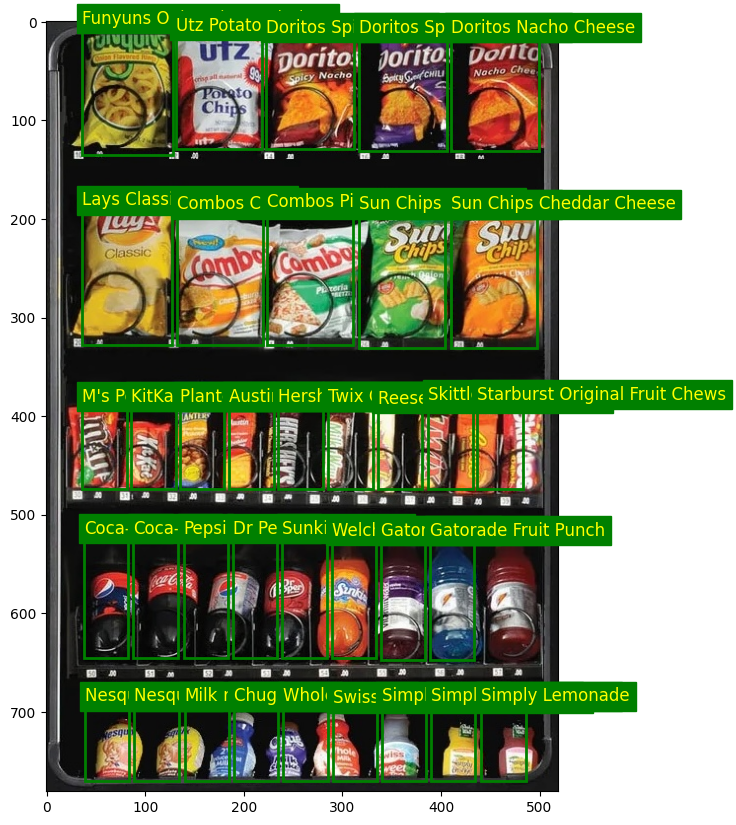

In [386]:
llm_responses = []
for test_sample in test_data:
  image = test_sample['image']
  image_fname = test_sample['filename']
  print(image_fname)
  llm_response = make_api_call(img_desc_prompt, image, gemini_model)
  print(llm_response.usage_metadata)
  text_content = getattr(llm_response, "text")
  print(gemini_model.model_name)
  # print(text_content)
  pred_labels = extract_pred_labels(text_content, image)
  llm_responses.append({'prompt': img_desc_prompt, 'model': gemini_model, 'response': llm_response, 'ref_labels': test_sample['labels'], 'pred_labels': pred_labels, 'image_fname': image_fname})



Test Results for vending2.jpg


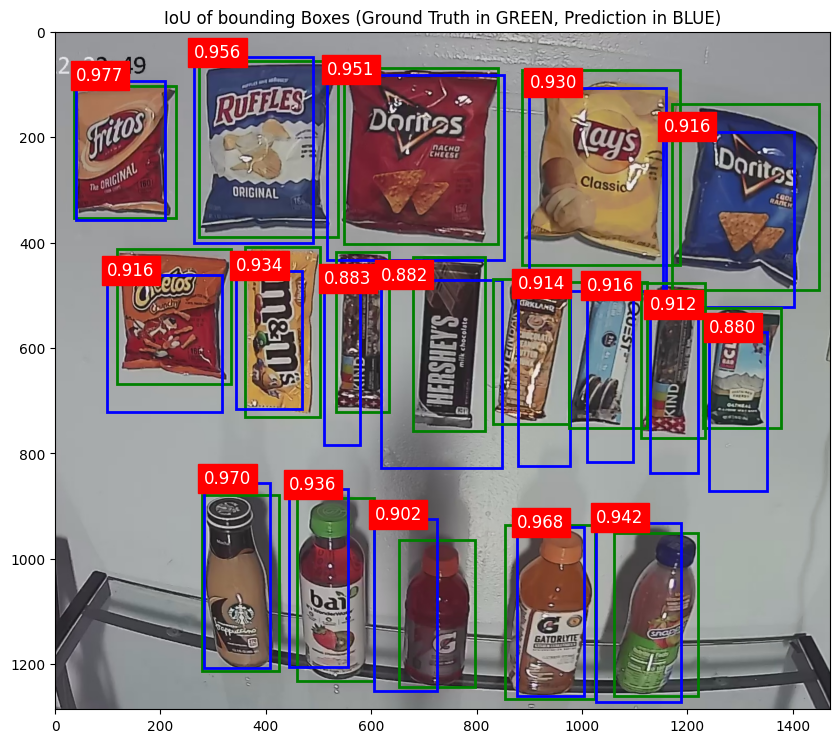

| Result   | Predicted Label                                                            | True Label              |  Matched Word Count  |   IoU    |
|:---------|:---------------------------------------------------------------------------|:------------------------|:--------------------:|:--------:|
| MATCH    | Fritos The Original Corn Chips                                             | Fritos The Original     |          3           | 0.976933 |
| MATCH    | Ruffles Original Potato Chips                                              | Ruffles Original        |          2           | 0.956027 |
| MATCH    | Doritos Nacho Cheese Flavored Tortilla Chips                               | Doritos Nacho Cheese    |          3           | 0.951284 |
| MATCH    | Lays Classic Potato Chips                                                  | Lays Classic            |          2           | 0.930178 |
| MATCH    | Doritos Cool Ranch Flavored Tortilla Chips                                 | Doritos Co

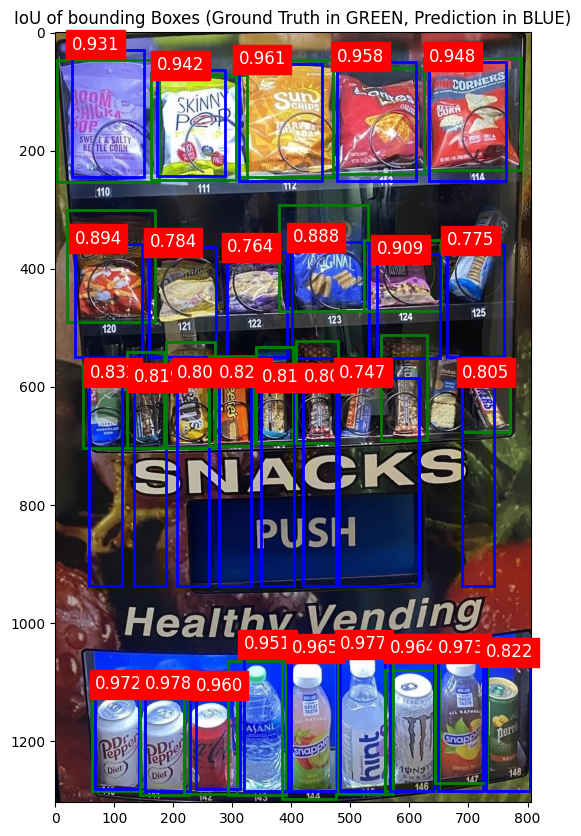

| Result   | Predicted Label                                       | True Label                  |  Matched Word Count  |   IoU    |
|:---------|:------------------------------------------------------|:----------------------------|:--------------------:|:--------:|
| MATCH    | Salty Kettle Corn                                     | Boom Chicka Pop Kettle Corn |          2           | 0.930693 |
| MATCH    | Skinny Pop Original Popcorn                           | Skinny Pop                  |          2           | 0.942201 |
| MATCH    | Sun Chips Harvest Cheddar Flavored Whole Grain Snacks | Sun Chips                   |          2           | 0.960583 |
| MATCH    | Doritos Nacho Cheese Flavored Tortilla Chips          | Doritos                     |          1           | 0.958048 |
| NO MATCH | Air Cornners White Cheddar Puffcorn                   | Pop Corners Kettle Corn     |          0           | 0.948233 |
| NO MATCH | Cheetos Flamin' Hot Cheese Flavored Snacks            | 

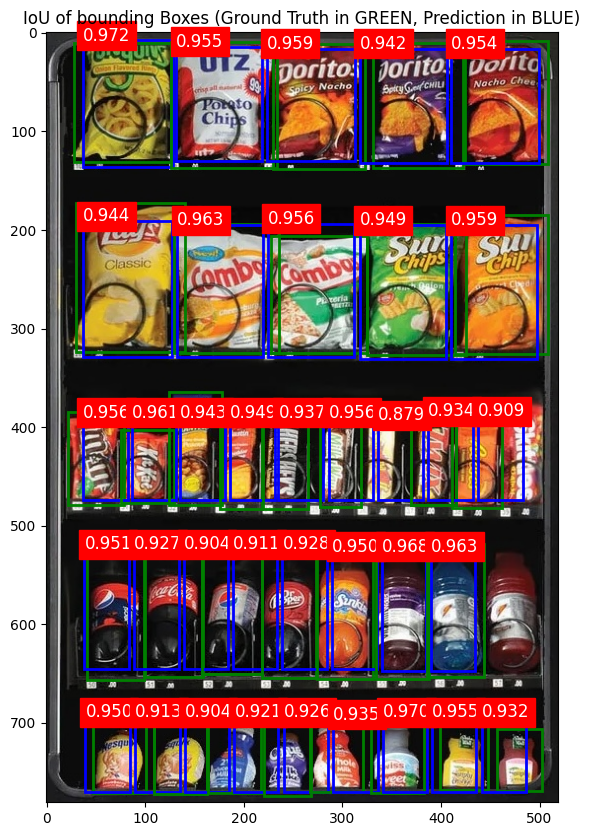

| Result   | Predicted Label                       | True Label                   |  Matched Word Count  |   IoU    |
|:---------|:--------------------------------------|:-----------------------------|:--------------------:|:--------:|
| MATCH    | Funyuns Onion Flavored Rings          | Funyuns Onion Flavored Rings |          4           | 0.972371 |
| MATCH    | Utz Potato Chips                      | Utz potato chips             |          3           | 0.954569 |
| MATCH    | Doritos Spicy Nacho                   | Doritos                      |          1           | 0.959116 |
| MATCH    | Doritos Spicy Sweet Chili             | Doritos                      |          1           | 0.941846 |
| MATCH    | Doritos Nacho Cheese                  | Doritos Nacho Cheese         |          3           | 0.954062 |
| MATCH    | Lays Classic Potato Chips             | Lays Classic                 |          2           | 0.943768 |
| MATCH    | Combos Cheddar Cheese Pretzel Snack   | Com

In [392]:
#@title Show Detection Results based on IoU measure and compute Accuracy Metrics
import pandas as pd

detection_results = []
for llm_output in llm_responses:
  fname = llm_output['image_fname']
  if fname == "vending2.jpg": ind = 0
  if fname == "vending5-1.jpg": ind = 1
  if fname == "vending3-1.jpg": ind = 2

  print(f"\nTest Results for {fname}")

  image = test_data[ind]['image']
  pred_labels = llm_output['pred_labels']
  ref_labels = llm_output['ref_labels']

  pred_results = get_pred_and_plot_results(image, pred_labels, ref_labels)

  accuracy, precision, recall, f1_score = compute_detection_metrics(pred_results)
  detection_results.append([fname, accuracy, precision, recall, f1_score])

In [394]:
#@title Detection Results Summary
# Create a DataFrame from the results list
df = pd.DataFrame(detection_results, columns=["Filename", "Accuracy", "Precision", "Recall", "F1 Score"])
# # Print the DataFrame as a table
print(df.to_markdown(index=False, numalign="center", stralign="left"))


| Filename       |  Accuracy  |  Precision  |  Recall  |  F1 Score  |
|:---------------|:----------:|:-----------:|:--------:|:----------:|
| vending2.jpg   |  0.777778  |  0.777778   |    1     |   0.875    |
| vending5-1.jpg |  0.642857  |  0.642857   |    1     |  0.782609  |
| vending3-1.jpg |  0.527778  |  0.527778   |    1     |  0.690909  |


**Important Note**: Below analysis is based on a small set of test images. More elaborate testing is required to quantify the model's performance. My goal is to do some quick testing for direction-check. If the model doesn't perform well with these samples images, I would take an alternate approach to solve the problem at hand.  

### Results Analysis
Gemini 1.5 Pro Multi-modal LLM was used in this zero-shot object detection test. The test was conducted on Oct-07-2024.

#### Key issues noticed:
1. A big issue with Gemini 1.5 Pro is that the class labels (list of product names) output by the model for the exact same input prompt (with the same image) varies from one call to another. There is lack of consistency/reproducability in what the LLM results.
2. The same prompt would output both a class label/product name and the bounding box for one image but not for another. The prompt had to be tweaked to include additional instructions to get the desired output.
3. When prompted to return the bounding box for the detect object in [x1, y1, x2, y2] format, 30-50% of the boxes were incorrect. However, the bounding boxes were more accurate when prompted to return in [y1, x1, y2, x2] format
4. Around 40% of the bounding boxes were too big - 2-3X bigger than the object itself.

Overall, considering this is zero-shot detection, the model's performance can be considered fair, however, I am asking the model to detect image classes that are widely available on the internet. Considering that these models are triained on copious amount of internet data, my expectation was that object detection would be more accurate.
In summary, this model is not suitable for my application that will require automatic class detection without any human-in-the-loop. The model accuracy is low (between 50-75%) in my tests whereas my goal is 99% accuracy.


In [401]:
#@title Cost of using Gemini Pro 1.5

print("\n Token Usage")
df = pd.DataFrame({'Image': ['vending2.jpg', 'vending3-1.jpg', 'vending5-1.jpg']})
df = pd.concat([df, pd.DataFrame({'Prompt Token Count': [309, 309, 309]})], axis=1)
df = pd.concat([df, pd.DataFrame({'Candidates Token Count': [440, 909, 755]})], axis=1)
df = pd.concat([df, pd.DataFrame({'Total Token Count': [749, 1218, 1064]})], axis=1)
print(df.to_markdown(index=False, numalign="left", stralign="left"))
#df

# Reference: https://cloud.google.com/vertex-ai/generative-ai/pricing
print("\n Gemini 1.5 Pro Pricing")
df = pd.DataFrame({'Token Type': ['Input: Image', 'Input: Text', 'Output: Text']})
df = pd.concat([df, pd.DataFrame({'Cost': ['$0.00002/image', '$0.00001875 / 1k characters','$0.000075 / 1k characters	']})], axis=1)
print(df.to_markdown(index=False, numalign="left", stralign="left"))


 Token Usage
| Image          | Prompt Token Count   | Candidates Token Count   | Total Token Count   |
|:---------------|:---------------------|:-------------------------|:--------------------|
| vending2.jpg   | 309                  | 440                      | 749                 |
| vending3-1.jpg | 309                  | 909                      | 1218                |
| vending5-1.jpg | 309                  | 755                      | 1064                |

 Gemini 1.5 Pro Pricing
| Token Type   | Cost                        |
|:-------------|:----------------------------|
| Input: Image | $0.00002/image              |
| Input: Text  | $0.00001875 / 1k characters |
| Output: Text | $0.000075 / 1k characters   |


Assuming there are 100 product purchases per vending machine per day, the number of API calls would be 3000 per month. At $0.0001 per call, I would spend about 30 cents per month per vending machine.
Cost-wise, this is definitely an attractive proposition but the reliability is lacking.